[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/tobyrmanders/statistical-rethinking/blob/main/code/chapter_04.ipynb)

In [6]:
import torch
from torch import tensor
import torch.distributions.constraints as constraints

import pyro
from pyro import distributions as dist
from pyro.infer.autoguide import AutoLaplaceApproximation
from pyro.infer import svi
from pyro import optim
import pyro.ops.stats as stats


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rethinking import MAP, coef, extract_samples, link, precis, sim, vcov

# 4E1

yi ∼ Normal(µ, σ) 

# 4E2

2

# 4E3

$
P(\mu, \sigma|y) = \frac{\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)}{\int\int\prod_i \text{Normal}(y_i|\mu,\sigma) \text{Normal}(\mu|0,10) \text{Exponential}(\sigma|1)d\mu d\sigma}
$

# 4E4

$\mu_i = \alpha + \beta x_i$

# 4E5

3

# 4M1

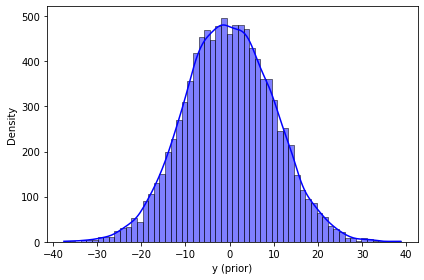

In [23]:
n_samples = 10_000
sample_mu = dist.Normal(tensor(0.), tensor(10.)).sample(torch.Size([n_samples]))
sample_sigma = dist.Exponential(tensor(1.),).sample(torch.Size([n_samples]))
prior_y = dist.Normal(sample_mu, sample_sigma).sample()
fig, ax = plt.subplots()
sns.histplot(prior_y.numpy(), color='blue', kde=True, ax=ax)
ax.set_xlabel('y (prior)')
ax.set_ylabel('Density')
fig.tight_layout()

<AxesSubplot:ylabel='Count'>

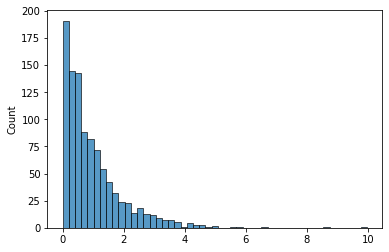

In [21]:
sns.histplot(sample_sigma)

# 4M2

In [265]:
# pyro model definition
pyro.clear_param_store()
def model_4m3(data=None, N=None):
    mu = pyro.sample('mu', dist.Normal(tensor(0.), tensor(10.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(1.),))
    if N is None:
        N = 1 if data is None else len(data)
    with pyro.plate('data', N):
        y = pyro.sample('y', dist.Normal(mu, sigma), obs=data)
        return y

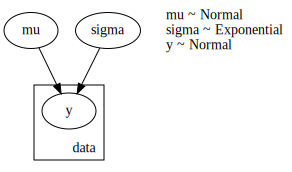

In [266]:
pyro.render_model(model_4m3, render_distributions=True, render_params=True)

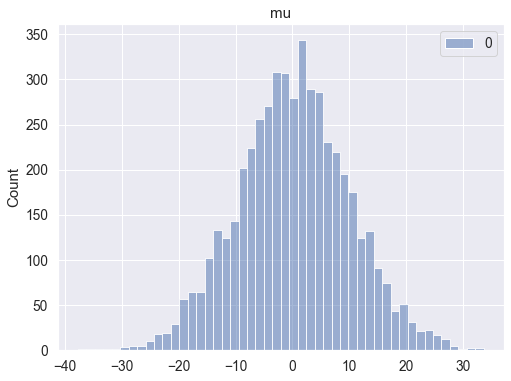

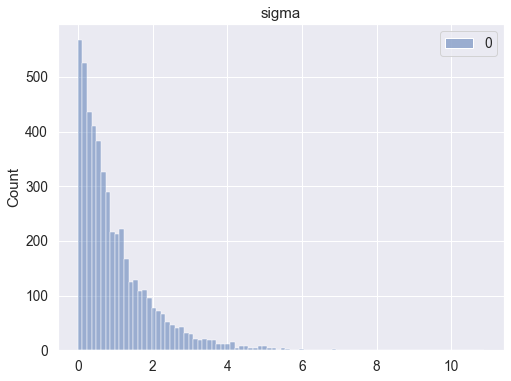

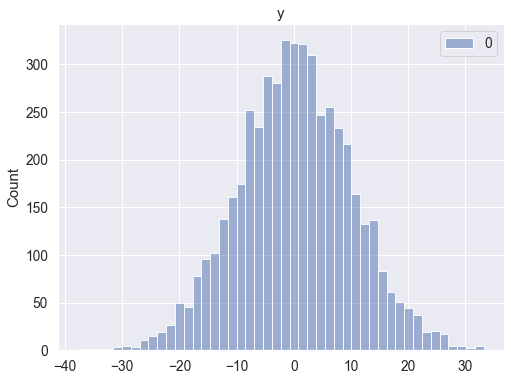

In [258]:
# prior predictive distribution
from pyro.infer import Predictive

x = model_4m3
prior_predictive = Predictive(model_4m3, {}, num_samples=5000)()
for site, values in prior_predictive.items():
    ax = sns.histplot(values)
    ax.set_title(site)
    plt.show()

# 4M3

mathematical model definition

$
y_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*x_i\newline
a \sim \text{Normal}(0, 10)\newline
b \sim \text{Uniform}(0, 1)\newline
\sigma \sim \text{Exponential}(1)\newline
$

# 4M4

$
height_i \sim \text{Normal}(\mu, \sigma)\newline
\mu_i = a + b*year_i\newline
a \sim \text{Normal}(160, 50)\newline
b \sim \text{Normal}(10, 5)\newline
\sigma \sim \text{Exponential}(1)\newline
$

In [47]:
dist.Uniform(1990, 2000).sample(torch.Size([5])).int()

tensor([1992, 1990, 1997, 1994, 1990], dtype=torch.int32)

<AxesSubplot:ylabel='Count'>

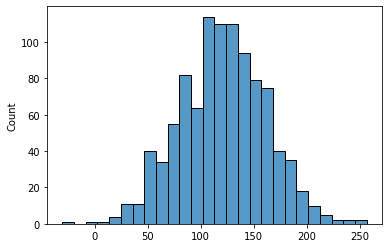

In [65]:
# intercept prior
a = dist.Normal(tensor(120.), tensor(40.)).sample(torch.Size([1000]))
sns.histplot(a)

<AxesSubplot:ylabel='Count'>

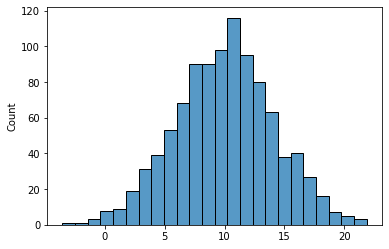

In [67]:
# slope prior
b = dist.Normal(tensor(10.), tensor(4.)).sample(torch.Size([1000]))
sns.histplot(b)

<AxesSubplot:ylabel='Count'>

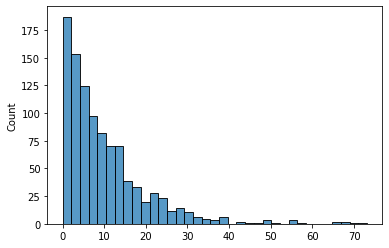

In [113]:
# slope prior
sigma = dist.Exponential(tensor(0.1)).sample(torch.Size([1000]))
sns.histplot(sigma)

In [123]:
def model_4m4(year=None, height=None, N=None):
    
    if year is not None:
        assert height is not None
        assert len(year)==len(height)
        assert isinstance(year, int)
        
    a = pyro.sample('a', dist.Normal(tensor(120.), tensor(40.)))
    b = pyro.sample('b', dist.Normal(tensor(10.), tensor(4.)))
    sigma = pyro.sample('sigma', dist.Exponential(tensor(.1),))
    
    if N is None:
        N = 1 if year is None else len(year)
        
    with pyro.plate('data_loop', N):
        year = pyro.sample('year', dist.Uniform(0, 10), obs=year).int()
#         print(year)
        mu = a + b * year
#         print(mu)
        height = pyro.sample('height', dist.Normal(mu, sigma), obs=height)
#         print(height)
        return year, height

In [124]:
# generate samples
pyro.clear_param_store()
year_samples, height_samples = model_4m4(N=2000)
print(f"{year_samples[:10]=}")
print(f"{height_samples[:10]=}")

year_samples[:10]=tensor([8, 8, 5, 9, 6, 2, 5, 5, 6, 0], dtype=torch.int32)
height_samples[:10]=tensor([283.0759, 298.9780, 224.5552, 300.6707, 249.4370, 175.2711, 235.8163,
        226.0534, 253.9278, 146.9803])


<AxesSubplot:>

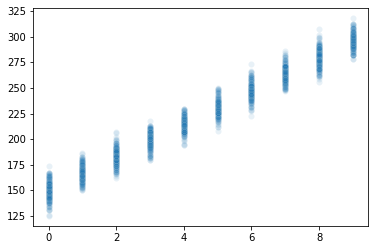

In [127]:
sns.scatterplot(x=year_samples, y=height_samples, alpha=0.1)

# 4M5

See prior above. Slope could be constrained to positive values. Could use half-Cauchy or half-Normal prior. 

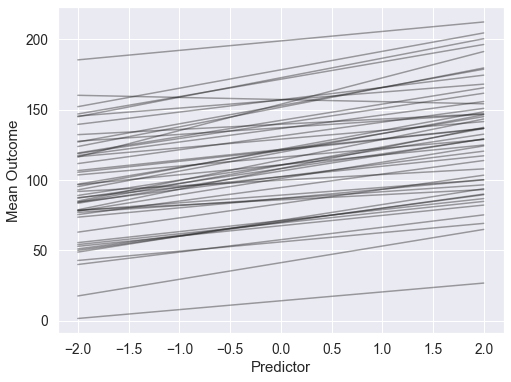

In [269]:
import numpy as np

# check that slope is positive
prior_predictive = Predictive(model_4m4, {}, num_samples=50)() 

def plot_predictive(prior_predictive):
    _, ax = plt.subplots()

    x = np.linspace(-2, 2, 50)

    for a, b in zip(prior_predictive["a"], prior_predictive["b"]):
        y = a + b * x
        ax.plot(x, y, c="k", alpha=0.4)

    ax.set_xlabel("Predictor")
    ax.set_ylabel("Mean Outcome")
    
plot_predictive(prior_predictive)

# 4M6

Sigma priors should be constrained to values uner sqrt(64) = 8.

<AxesSubplot:ylabel='Count'>

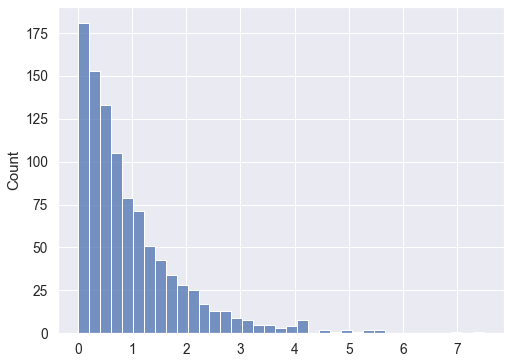

In [276]:
# check that this is already true
sns.histplot(dist.Exponential(1).sample(torch.Size([int(1e3)])))

# 4M7

In [3]:
import pandas as pd

d = pd.read_csv("../data/Howell1.csv", sep=";")
d = d[d["age"] >= 18]

<AxesSubplot:ylabel='Frequency'>

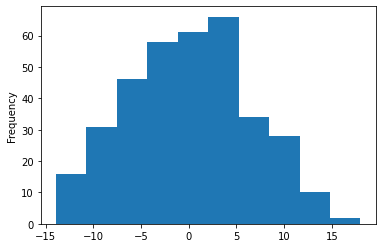

In [4]:
d['weight_c'] = d.weight - d.weight.mean()
d.weight_c.plot(kind='hist')

In [7]:
# First, calculate xbar
df = d[['height', 'weight', 'weight_c']]
train = torch.tensor(df.values, dtype=torch.float)
height, weight, weight_c = train[:, 0], train[:, 1], train[:, 2]

[Text(0.5, 0, 'weight (centered)'), Text(0, 0.5, 'height')]

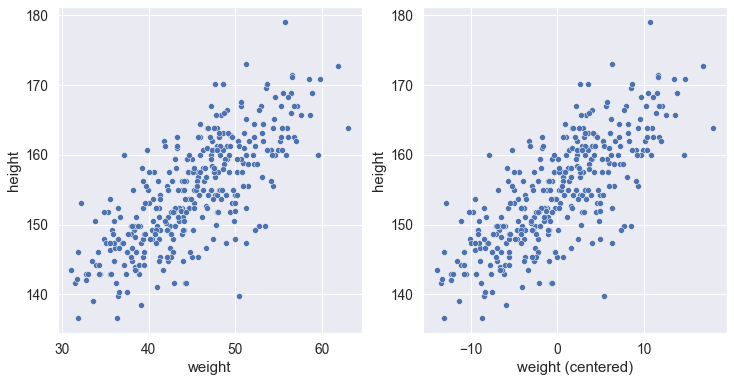

In [8]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.scatterplot(x=weight, y=height, ax=ax[0])
ax[0].set(xlabel='weight', ylabel='height')
sns.scatterplot(x=weight_c, y=height, ax=ax[1])
ax[1].set(xlabel='weight (centered)', ylabel='height')

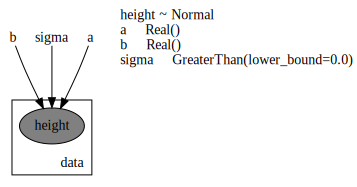

In [11]:
# MLE version

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(weight=None, height=None):
    a = pyro.param("a", dist.Normal(160, 20))
    b = pyro.param("b", dist.Normal(0, 10))
    sigma = pyro.param("sigma", dist.Uniform(0, 50), constraint=constraints.positive)
    
    mu = a + b * weight
    
    with pyro.plate('data'):
        return pyro.sample("height", dist.Normal(mu, sigma), obs=height)
    
pyro.render_model(model, model_args=(weight, height), render_distributions=True, render_params=True)

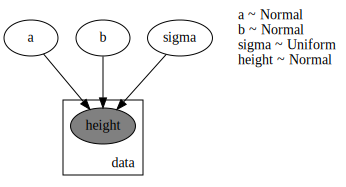

In [9]:
# Bayesian version

import pyro.distributions as dist
import pyro.distributions.constraints as constraints

def model(weight=None, height=None):
    a = pyro.sample("a", dist.Normal(160, 20))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    
    mu = a + b * weight
    
    with pyro.plate('data'):
        return pyro.sample("height", dist.Normal(mu, sigma), obs=height)
    
pyro.render_model(model, model_args=(weight_c, height), render_distributions=True, render_params=True)

Elbo loss: 7837.840719103813
Elbo loss: 4436.041224956512
Elbo loss: 3865.103474855423
Elbo loss: 3597.181774675846
Elbo loss: 3537.899352788925
Elbo loss: 3398.9714111685753
Elbo loss: 3334.2721185088158
Elbo loss: 3272.544098138809
Elbo loss: 3269.8008812069893
Elbo loss: 3207.255917608738
CPU times: user 3.19 s, sys: 17.4 ms, total: 3.2 s
Wall time: 3.21 s


Text(0, 0.5, 'ELBO loss')

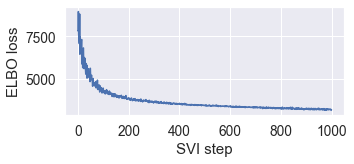

In [10]:
%%time
# mean-field variational approximation
# models distribution of unobserved parameters as a gaussian with diagonal covariance
# assumes there is non correlation between latent variables

pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(weight_c, height)
    losses.append(loss)
    if step % 100 == 0:
        print("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

Sometimes models and guides are sensitive to learning rate, and the first thing to try is decreasing learning rate and increasing number of steps.

In [11]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 14.95476
AutoNormal.scales.a 1.217341
AutoNormal.locs.b 0.9589403
AutoNormal.scales.b 0.3642165
AutoNormal.locs.sigma 3.872998
AutoNormal.scales.sigma 0.09631919


In [12]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(weight_c, height)
    
b_learned = samples['b']

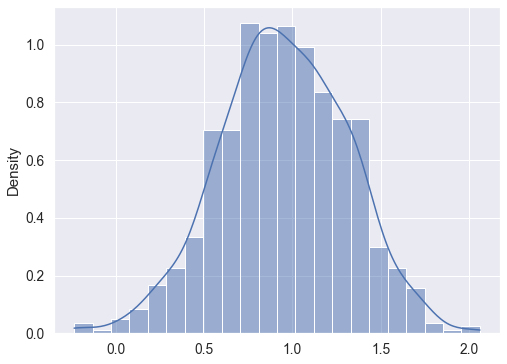

In [13]:
ax = sns.histplot(b_learned.detach().cpu().numpy(), kde=True, stat="density")

In [15]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(weight_c, height=None)
svi_height = svi_samples["height"]

In [16]:
print(svi_height.shape)
svi_height

torch.Size([800, 352])


tensor([[ -26.9599,   -2.0927,   28.0222,  ...,   39.8308,  163.2501,
          -61.3402],
        [  61.4032, -108.6214,   -0.7301,  ...,   45.9826,   46.4107,
          141.0305],
        [ -40.2539,   42.2796,   26.6240,  ...,  -55.3909,   29.2191,
            8.6538],
        ...,
        [  33.0042,    9.2404,  -40.5989,  ...,  -33.6570,   61.7332,
          -35.4232],
        [ -15.5025,  -33.9450,  -29.0761,  ...,   38.6485,  -29.5419,
           96.7294],
        [ -37.4307,    2.7795,  -33.3595,  ...,   88.6888,   49.2475,
          101.0419]])

[Text(0.5, 0, 'weight (centered)'), Text(0, 0.5, 'height')]

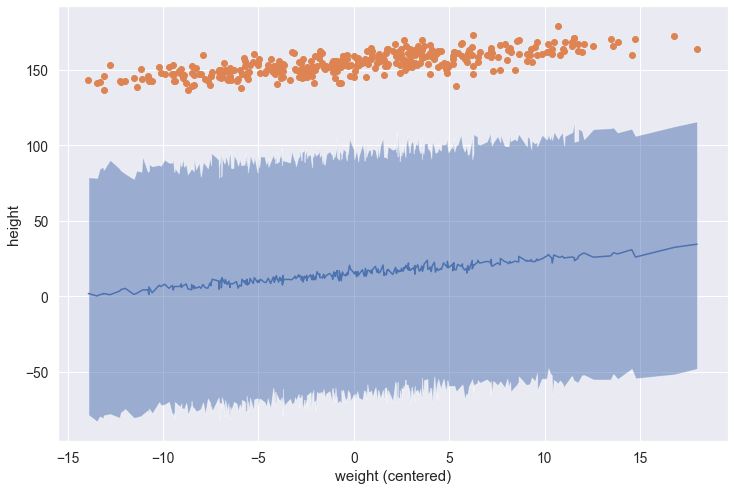

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

predictions = pd.DataFrame({
    'weight': weight_c,
    "h_mean": svi_height.mean(0).detach().cpu().numpy(),
    "h_perc_5": svi_height.kthvalue(int(len(svi_height) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "h_perc_95": svi_height.kthvalue(int(len(svi_height) * 0.95), dim=0)[0].detach().cpu().numpy(),
    'true_height': height,
}).sort_values(by='weight')

f, ax = plt.subplots(figsize=(12,8))

ax.plot(predictions['weight'], predictions['h_mean'])
ax.fill_between(predictions['weight'], predictions['h_perc_5'], predictions['h_perc_95'], alpha=0.5)

ax.plot(predictions['weight'], predictions['true_height'], "o")
ax.set(xlabel='weight (centered)', ylabel='height')

In [36]:
predictions

,weight,h_mean,h_perc_5,h_perc_95,true_height
155,-13.919434,143.509995,143.509995,143.509995,143.509995
137,-13.465841,141.604996,141.604996,141.604996,141.604996
257,-13.324094,142.240005,142.240005,142.240005,142.240005
2,-13.125648,136.524994,136.524994,136.524994,136.524994
179,-13.125648,146.050034,146.050003,146.050003,146.050003
...,...,...,...,...,...
227,13.834727,168.910004,168.910004,168.910004,168.910004
233,14.571814,160.020004,160.020004,160.020004,160.020004
103,14.770261,170.814957,170.815002,170.815002,170.815002
135,16.811424,172.720001,172.720001,172.720001,172.720001


# 4M8
Code example for splines not available. Probably need to implement from scratch. 
https://docs.pyro.ai/en/stable/_modules/pyro/distributions/transforms/spline.html

# 4H1

In [199]:
weights = torch.tensor([46.95, 43.72, 64.78, 32.59, 54.63])
pred_heights = sim(m4_3, data={'weight': weights})

In [200]:
pred_heights.shape

torch.Size([1000, 5])

In [203]:
height_mean = pred_heights.mean(0)
height_mean

tensor([247.8079, 244.6785, 262.1838, 233.8176, 253.1528])

In [201]:
height_PI = stats.pi(pred_heights, prob=0.89, dim=0)

In [202]:
height_PI

tensor([[186.0733, 181.8310, 201.0557, 174.0015, 192.1495],
        [305.6400, 310.0035, 324.4444, 291.4416, 312.2299]])

# 4H2

In [246]:
howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = howell1
d2 = d[d["age"] < 18]

def model(weight, height):
    a = pyro.sample("a", dist.Normal(100, 100))
    b = pyro.sample("b", dist.Normal(0, 10))
    sigma = pyro.sample("sigma", dist.Uniform(0, 50))
    with pyro.plate("plate"):
        pyro.sample("height", dist.Normal(a + b * weight, sigma), obs=height)

m4h2 = MAP(model).run(d2_weight, d2_height)

In [247]:
precis(m4h2, corr=True)

,Mean,StdDev,|0.89,0.89|,a,b,sigma
a,111.84,13.92,89.49,133.72,1.00,-0.94,-0.01
b,-2.67,0.32,-3.19,-2.16,-0.94,1.00,-0.30
sigma,37.25,0.51,36.43,38.05,-0.01,-0.30,1.00


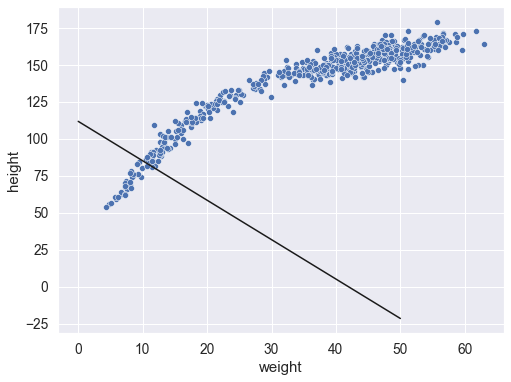

In [248]:
sns.scatterplot("weight", "height", data=d)
x = torch.linspace(0, 50, 101)
sns.lineplot(x, (coef(m4h2)["a"] + coef(m4h2)["b"] * x), color="k");